In [11]:
import os
os.environ["STPSF_PATH"] = "/d/ret1/Taylor/stpsf-data/" 
import webbpsf
os.environ["STPSF_PATH"] = "/d/ret1/Taylor/stpsf-data/" #TJ for some reason this only works if you do this line twice... no idea why

print(os.path.exists(os.environ["STPSF_PATH"]))
print(os.environ["STPSF_PATH"]) #TJ check that this kernel has access to the filter files
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import sys
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm
from ipywidgets import interact, Dropdown
from astropy.wcs import WCS
from astropy.constants import c
from photutils.aperture import CircularAperture, aperture_photometry
import astropy.units as u
from astropy.table import Table
from tabulate import tabulate
from pathlib import Path
from tqdm.notebook import tqdm
from astropy.convolution import convolve_fft, Gaussian2DKernel


#parent_dir = Path().resolve().parent #TJ current notebook's parent directory

os.chdir('/d/ret1/Taylor/jupyter_notebooks/Research') #TJ change working directory to be the parent directory
from Py_files.Basic_analysis import * #import basic functions from custom package
from Py_files.Image_vs_spectra import * 
#TJ import flux calibration functions (mainly compare_IFU_to_image(IFU_filepath, image_filepath, filter_filepath, loc, radius))

def get_filter_wl_range(filter):
    '''Use the filter files to determine what wavelength range we need for each filter
    -------------
    
    Parameters
    -------------
    filter : type = str - string describing the filter name (case sensitive), for example "F335M"

    Returns
    -------------
    Path to newly convolved file as a string
    '''   
    filter_files = ['/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F115W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F140M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F150W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F164N.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F182M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F187N.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F200W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F210M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F212N.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F250M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F300M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F335M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F360M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F405N.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F430M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F444W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F560W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F770W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F1000W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F1130W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F1280W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F1500W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F1800W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F2100W.dat']
    filter_file = [filer_filepath for filer_filepath in filter_files if extract_filter_name(filer_filepath).upper() == filter][0]
    filter_data = []
    with open(filter_file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)

    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    return filter_wl[0]*u.m, filter_wl[-1]*u.m

def convolve(IFU_fits_file, instrument, filter, output_file = None):
    '''Convolve an IFU cube to the PSF of the provided filter.
    -------------
    
    Parameters
    -------------
    IFU_fits_file : type = str - string to location of IFU fits that you want to convolve.
    instrument : type = str - Either "MIRI" or "NIRCam" depending on wavelength
    filter : type = str - string describing the filter name (case sensitive), for example "F335M"
    output_file (optional, defaults to use the IFU_file with _convolved_to_{filter}) : type = str - name of the convolved file
    
    Returns
    -------------
    Path to newly convolved file as a string
    '''   

    IFU_hdul = fits.open(IFU_fits_file)
    header = IFU_hdul["SCI"].header
    cube = SpectralCube.read(IFU_fits_file, hdu='SCI')
    spectral_axis = cube.spectral_axis  #TJ in meters
    # === Load webbpsf instrument ===
    if instrument == 'NIRCam':
        inst = webbpsf.NIRCam()
    elif instrument == "MIRI":
        inst = webbpsf.MIRI()
    inst.filter = filter

    # === Prepare output cube ===
    convolved_data = np.zeros_like(cube.unmasked_data[:].value)
    tqdm_kwargs = {
        'dynamic_ncols': True,  # Auto-adjusts width
        'mininterval': 0.5,     # Update every 0.5 seconds (optional)
        'position': 0,          # Fix position (set to 0 for notebooks)
        'leave': True           # Leaves progress bar after completion
    }
    # === Loop through wavelengths and convolve ===
    for i, wavelength in enumerate(tqdm(spectral_axis, desc=f"Convolving to {filter}")):
        psf = inst.calc_psf(monochromatic=wavelength.to(u.m).value)    
        psf_data = psf[0].data
        psf_data /= psf_data.sum()  # Normalize PSF to conserve flux
    
        image_slice = cube.filled_data[...].value[i]  # 2D image at this wavelength
        convolved_slice = convolve_fft(image_slice, psf_data, normalize_kernel=True, boundary='fill', fill_value=0)
        convolved_data[i] = convolved_slice
    
    # === Save the convolved cube ===
    out_hdu = fits.PrimaryHDU(convolved_data, header=header)
    if output_file:
        out_hdu.writeto(f"Data_files/IFU_files/{output_file}", overwrite=True)
        print(f"✅ PSF convolution complete and saved as {output_file}")
        return f"Data_files/IFU_files/{output_file}"
    else:
        out_hdu.writeto(f"Data_files/IFU_files/{IFU_fits_file}_convolved_to_{filter}.fits", overwrite=True)
        print(f"✅ PSF convolution complete and saved as {IFU_fits_file}_convolved_to_{filter}")
        return f"Data_files/IFU_files/{IFU_fits_file}_convolved_to_{filter}.fits"

        
    


True
/d/ret1/Taylor/stpsf-data/


In [12]:
# === User Inputs ===

if __name__ == "__main__":
    #TJ add the path to psf data files if needed (may need to go back through adding the path in terminal)
    #filters = ['F335M', 'F360M', 'F405N', 'F430M', 'F444W']
    filters = ['F335M', 'F360M', 'F405N', 'F430M', 'F444W', 'F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W'] 
    # === Set up ===
    
    for filter in filters:
        if filter in ['F335M', 'F360M', 'F405N', 'F430M', 'F444W']:
            IFU_filepath = "Data_files/IFU_files/M51_SW_f290lp_g395m-f290lp_s3d.fits"
            instrument = 'NIRCam'  # or 'MIRI' if using MIRI cube
        if filter in ['F560W']:
            IFU_filepath = 'Data_files/IFU_files/SW_IFU_ch1-shortmediumlong_s3d.fits'
            instrument = "MIRI"
        if filter in ['F770W', 'F1000W']:
            IFU_filepath = 'Data_files/IFU_files/SW_IFU_ch2-shortmediumlong_s3d.fits'
            instrument = "MIRI"
        if filter in ['F1130W', 'F1280W', 'F1500W']:
            IFU_filepath = 'Data_files/IFU_files/SW_IFU_ch3-shortmediumlong_s3d.fits'
            instrument = "MIRI"
        if filter in ['F1800W', 'F2100W']:
            IFU_filepath = 'Data_files/IFU_files/SW_IFU_ch4-shortmediumlong_s3d.fits'
            instrument = "MIRI"
            
        IFU_hdul = fits.open(IFU_filepath)
        header = IFU_hdul["SCI"].header
        cube = SpectralCube.read(IFU_filepath, hdu='SCI')
        wcs = WCS(header)
        spectral_axis = cube.spectral_axis  #TJ in meters
        # === Load webbpsf instrument ===
        if instrument == 'NIRCam':
            inst = webbpsf.NIRCam()
        elif instrument == "MIRI":
            inst = webbpsf.MIRI()
        inst.filter = filter
    
        # === Prepare output cube ===
        convolved_data = np.zeros_like(cube.unmasked_data[:].value)
        tqdm_kwargs = {
            'dynamic_ncols': True,  # Auto-adjusts width
            'mininterval': 0.5,     # Update every 0.5 seconds (optional)
            'position': 0,          # Fix position (set to 0 for notebooks)
            'leave': True           # Leaves progress bar after completion
        }
        # === Loop through wavelengths and convolve ===
        for i, wavelength in enumerate(tqdm(spectral_axis, desc=f"Convolving to {filter}")):
            psf = inst.calc_psf(monochromatic=wavelength.to(u.m).value)    
            psf_data = psf[0].data
            psf_data /= psf_data.sum()  # Normalize PSF to conserve flux
        
            image_slice = cube.filled_data[...].value[i]  # 2D image at this wavelength
            convolved_slice = convolve_fft(image_slice, psf_data, normalize_kernel=True, boundary='fill', fill_value=0)
            convolved_data[i] = convolved_slice
        
        # === Save the convolved cube ===
        out_hdu = fits.PrimaryHDU(convolved_data, header=header)
        out_hdu.writeto(f"Data_files/IFU_files/M51_IFU_convolved_to_{inst.filter}.fits", overwrite=True)
        
        print("✅ PSF convolution complete and saved as 'M51_IFU_convolved.fits'")


FileNotFoundError: [Errno 2] No such file or directory: 'Data_files/IFU_files/M51_SW_f290lp_g395m-f290lp_s3d.fits'

In [18]:
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.signal import fftconvolve
import astropy.units as u
from astropy.nddata import Cutout2D
from matplotlib import colors


def generate_psf(
    psf_type,
    fwhm_pix=None,
    size=51,
    psf_array=None
):
    """
    Generate a 2D PSF kernel.

    Parameters
    ----------
    psf_type : str
        Type of PSF. Options:
        - 'gaussian'
        - 'array' (user-supplied PSF)
    fwhm_pix : float, optional
        FWHM of Gaussian PSF in pixels (required if psf_type='gaussian')
    size : int
        Size of PSF array (must be odd)
    psf_array : 2D ndarray, optional
        User-provided PSF array (required if psf_type='array')

    Returns
    -------
    psf : 2D ndarray
        Normalized PSF kernel
    """

    if size % 2 == 0:
        raise ValueError("PSF size must be odd.")

    if psf_type == "gaussian":
        if fwhm_pix is None:
            raise ValueError("fwhm_pix must be provided for Gaussian PSF.")

        sigma = fwhm_pix / (2.0 * np.sqrt(2.0 * np.log(2.0)))

        y, x = np.mgrid[:size, :size]
        cy = cx = size // 2

        psf = np.exp(-((x - cx)**2 + (y - cy)**2) / (2.0 * sigma**2))

    elif psf_type == "array":
        if psf_array is None:
            raise ValueError("psf_array must be provided for psf_type='array'")
        psf = np.array(psf_array, dtype=float)

    else:
        raise ValueError(f"Unknown psf_type: {psf_type}")

    # Normalize to unit integral (flux-conserving)
    psf /= np.sum(psf)

    return psf


from astropy.io import fits
import os


def convolve_ifu_cube(
    ifu_fits_path,
    psf,
    output_path,
    ext='SCI'
):
    """
    Convolve an IFU cube spatially with a PSF and save the result.

    Parameters
    ----------
    ifu_fits_path : str
        Path to input IFU FITS file
    psf : 2D ndarray
        PSF kernel (must be normalized)
    output_path : str
        Path to save convolved FITS file
    ext : int
        FITS extension containing the data cube

    Returns
    -------
    None
    """

    with fits.open(ifu_fits_path) as hdul:
        data = hdul[ext].data
        header = hdul[ext].header

    # Expected shape: (n_lambda, ny, nx)
    if data.ndim != 3:
        raise ValueError("Expected IFU cube with shape (n_lambda, ny, nx)")

    n_lambda, ny, nx = data.shape
    convolved = np.full_like(data, np.nan)

    for k in range(n_lambda):
        slice_k = data[k]

        if np.all(~np.isfinite(slice_k)):
            continue

        # Replace NaNs with zero for convolution
        mask = np.isfinite(slice_k)
        slice_filled = np.zeros_like(slice_k)
        slice_filled[mask] = slice_k[mask]

        conv = fftconvolve(slice_filled, psf, mode="same")

        # Renormalize to avoid edge bias
        weight = fftconvolve(mask.astype(float), psf, mode="same")
        good = weight > 0
        conv[good] /= weight[good]
        conv[~good] = np.nan

        convolved[k] = conv

    # Save output
    hdu = fits.PrimaryHDU(convolved, header=header)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    hdu.writeto(output_path, overwrite=True)
    return output_path

In [6]:
import os
os.chdir('/d/ret1/Taylor/jupyter_notebooks/Research') #TJ change working directory to be the parent directory
from Py_files.Functions import *
image_files, filter_files = generate_list_of_files(filter_directory, image_directory)

full_raw_ifu_files_loc0 = ['Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g140m-f100lp_s3d_trimmed.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g235m-f170lp_s3d_trimmed.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch1-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch2-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch3-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch4-shortmediumlong_s3d_trimmed.fits']

psf = generate_psf(
    psf_type="gaussian",
    fwhm_pix=2.3,
    size=61
)

# Apply convolution
test_convolution = []
for i, file in enumerate(full_raw_ifu_files_loc0):
    new_file = convolve_ifu_cube(ifu_fits_path=file, psf=psf, output_path=f"Data_files/misc_data/test_data/testing_convolutions_{i}.fits")
    test_convolution.append(new_file)

Some functions use pre-defined data files, a warning will print when this is the case.
Current default filter data directory /d/crow1/tools/cigale/database_builder/filters/jwst/
Current default image directory Data_files/Image_files/v0p3/
Wavelength-sorted lists of files saved to variables 'filter_files' and 'image_files'
Regenerate sorted lists using 'image_files, filter_files = generate_list_of_files(filter_directory, image_directory)'
JWST filter mean wavelengths stored as dictionary, called using jwst_means["F115W"]


FileNotFoundError: [Errno 2] No such file or directory: 'Data_files/IFU/ngc5194_nirspec_cube.fits'

<Quantity [2.87089489, 2.87268489, 2.87447489, ..., 5.2659149 , 5.2677049 ,
           5.2694949 ] um>

In [9]:
def show_image_and_synth(filter, ifu_fileset, loc, radius, image_files=image_files, color_min_max = [1, 99.5]):
    """
    Show real image and synthetic IFU-derived image side by side.
    Works with either one or two IFU cubes needed for the filter.
    """

    # ------------------------------------------------------------
    # Location handling
    # ------------------------------------------------------------
    if not isinstance(loc, SkyCoord):
        loc_sky = SkyCoord(ra=loc[0] * u.deg, dec=loc[1] * u.deg, frame="icrs")
    else:
        loc_sky = loc

    def nearest_spaxel_map(cube_src, cube_target):
        ny, nx = cube_target.shape[1:]
        y_t, x_t = np.mgrid[:ny, :nx]

        world = cube_target.wcs.celestial.pixel_to_world(x_t, y_t)
        x_s, y_s = cube_src.wcs.celestial.world_to_pixel(world)

        x_s = np.clip(np.round(x_s).astype(int), 0, cube_src.shape[2] - 1)
        y_s = np.clip(np.round(y_s).astype(int), 0, cube_src.shape[1] - 1)

        return y_s, x_s

    # ------------------------------------------------------------
    # Locate real image
    # ------------------------------------------------------------
    real_image_file = [x for x in image_files if extract_filter_name(x) == filter][0]
    
    short_wl, long_wl = [x.value for x in get_filter_wl_range(filter)]

    needed_ifus = []
    for file in ifu_fileset:
        wl = SpectralCube.read(file, hdu="SCI").spectral_axis.to(u.m).value
        if (wl[0] < short_wl) and (wl[-1] > long_wl):
            needed_ifus = [file]
            break
        if (long_wl > wl[0]) and (short_wl < wl[-1]):
            needed_ifus.append(file)
        if len(needed_ifus) > 1:
            break

    cube1 = SpectralCube.read(needed_ifus[0], hdu="SCI")
    cube2 = SpectralCube.read(needed_ifus[1], hdu="SCI") if len(needed_ifus) > 1 else None

    # ------------------------------------------------------------
    # Base cube quantities
    # ------------------------------------------------------------
    wl1 = cube1.spectral_axis.to(u.m).value
    d1 = cube1.unmasked_data[:].value

    ny, nx = cube1.shape[1:]
    n_pix = ny * nx
    d1 = d1.reshape(len(wl1), n_pix).T

    # ------------------------------------------------------------
    # Stitch spectra if needed
    # ------------------------------------------------------------
    if cube2 is not None:
        wl2 = cube2.spectral_axis.to(u.m).value
        d2 = cube2.unmasked_data[:].value

        y2, x2 = nearest_spaxel_map(cube2, cube1)
        d2 = d2[:, y2, x2].reshape(len(wl2), n_pix).T

        wl_all = np.concatenate([wl1, wl2])
        sort_idx = np.argsort(wl_all)
        wl_all = wl_all[sort_idx]

        spec_all = np.concatenate([d1, d2], axis=1)[:, sort_idx]

        wl_min = max(wl1.min(), wl2.min())
        wl_max = min(wl1.max(), wl2.max())
        overlap = (wl_all >= wl_min) & (wl_all <= wl_max)
        both = np.isin(wl_all, wl1) & np.isin(wl_all, wl2) & overlap
        spec_all[:, both] *= 0.5
    else:
        wl_all = wl1
        spec_all = d1

    # ------------------------------------------------------------
    # Synthetic photometry
    # ------------------------------------------------------------
    filter_wl, filter_trans = get_filter_data(filter)

    image = np.empty(n_pix)
    for i in range(n_pix):
        image[i] = get_Fnu_transmission(
            spec_all[i], wl_all, filter_trans, filter_wl, warnings=True
        )

    synth_image = image.reshape(ny, nx)

    # ------------------------------------------------------------
    # Attach WCS to synthetic image
    # ------------------------------------------------------------
    synth_hdu = fits.PrimaryHDU(
        synth_image,
        header=cube1.wcs.celestial.to_header()
    )

    # ------------------------------------------------------------
    # Plot real vs synthetic
    # ------------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # -------------------------
    # REAL IMAGE
    # -------------------------
    hdu = fits.open(real_image_file)["SCI"]
    real_pix_size = hdu.header['PIXAR_A2']**0.5
    aperture_radius = radius.to(u.arcsec).value / real_pix_size
    cutout_real = Cutout2D(
        hdu.data,
        position=loc_sky,
        size=(radius * 3, radius * 3),
        wcs=WCS(hdu.header)
    )

    # -------------------------
    # SYNTHETIC IMAGE (WCS CUTOUT)
    # -------------------------
    cutout_synth = Cutout2D(
        synth_hdu.data,
        position=loc_sky,
        size=(radius * 3, radius * 3),
        wcs=WCS(synth_hdu.header)
    )

    # ------------------------------------------------------------
    # Shared normalization (1–99%)
    # ------------------------------------------------------------
    combined = np.concatenate([
        cutout_real.data[np.isfinite(cutout_real.data)],
        cutout_synth.data[np.isfinite(cutout_synth.data)]
    ])

    vmin = np.percentile(combined, color_min_max[0])
    vmax = np.percentile(combined, color_min_max[1])

    cmap = plt.get_cmap("viridis").copy()
    cmap.set_under("black")
    cmap.set_over("white")
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

    pix_scale = np.abs(cutout_synth.wcs.wcs.cdelt[0]) * 3600
    r_ap_pix = radius.to(u.arcsec).value / pix_scale

    # -------------------------
    # PLOT REAL
    # -------------------------
    im0 = axes[0].imshow(
        cutout_real.data,
        origin="lower",
        cmap=cmap,
        norm=norm
    )
    axes[0].set_title(f"{filter} – Real")

    cbar0 = plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    cbar0.set_label("Flux", fontsize=14)
    cbar0.ax.tick_params(labelsize=12)

    x_r, y_r = cutout_real.wcs.world_to_pixel(loc_sky)
    axes[0].add_patch(
        Circle((x_r, y_r), aperture_radius, edgecolor="red", facecolor="none", linewidth=2)
    )

    # -------------------------
    # PLOT SYNTHETIC
    # -------------------------
    im1 = axes[1].imshow(
        cutout_synth.data,
        origin="lower",
        cmap=cmap,
        norm=norm
    )
    axes[1].set_title(f"{filter} – Synthetic (IFU)")

    cbar1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    cbar1.set_label("Flux", fontsize=14)
    cbar1.ax.tick_params(labelsize=12)

    x_s, y_s = cutout_synth.wcs.world_to_pixel(loc_sky)
    axes[1].add_patch(
        Circle((x_s, y_s), r_ap_pix, edgecolor="red", facecolor="none", linewidth=2)
    )

    # -------------------------
    # Cleanup
    # -------------------------
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

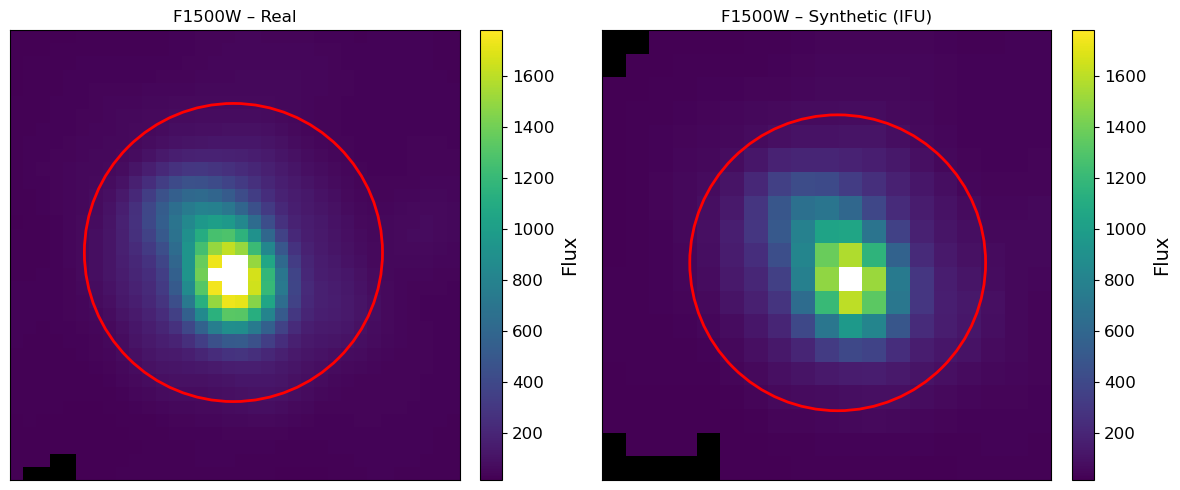

In [14]:
image_files = ['Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f115w.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f140m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f150w.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f164n.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f182m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f187n.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f200w.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f210m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f212n.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f250m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f300m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f335m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f360m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f405n.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f430m.fits',
       'Data_files/Image_files/v0p3/ngc5194_nircam_lv3_f444w.fits',
       'Data_files/Image_files/v0p3/ngc5194_miri_lv3_f560w.fits',
       'Data_files/Image_files/v0p3/ngc5194_miri_lv3_f770w.fits',
       'Data_files/Image_files/v0p3/ngc5194_miri_lv3_f1000w.fits',
       'Data_files/Image_files/v0p3/ngc5194_miri_lv3_f1130w.fits',
       'Data_files/Image_files/v0p3/ngc5194_miri_lv3_f1280w.fits',
       'Data_files/Image_files/v0p3/ngc5194_miri_lv3_f1500w.fits',
       'Data_files/Image_files/v0p3/ngc5194_miri_lv3_f1800w.fits',
       'Data_files/Image_files/v0p3/ngc5194_miri_lv3_f2100w.fits']

locations = [[202.5062429, 47.2143358], [202.4335225, 47.1729608], [202.4340450, 47.1732517], [202.4823742, 47.1958589]]
radius = 1.25*u.arcsec
full_raw_ifu_files_loc0 = ['Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g140m-f100lp_s3d_trimmed.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g235m-f170lp_s3d_trimmed.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch1-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch2-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch3-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch4-shortmediumlong_s3d_trimmed.fits']
show_image_and_synth('F1500W', full_raw_ifu_files_loc0, locations[0], radius, image_files=image_files, color_min_max = [1, 99.5])

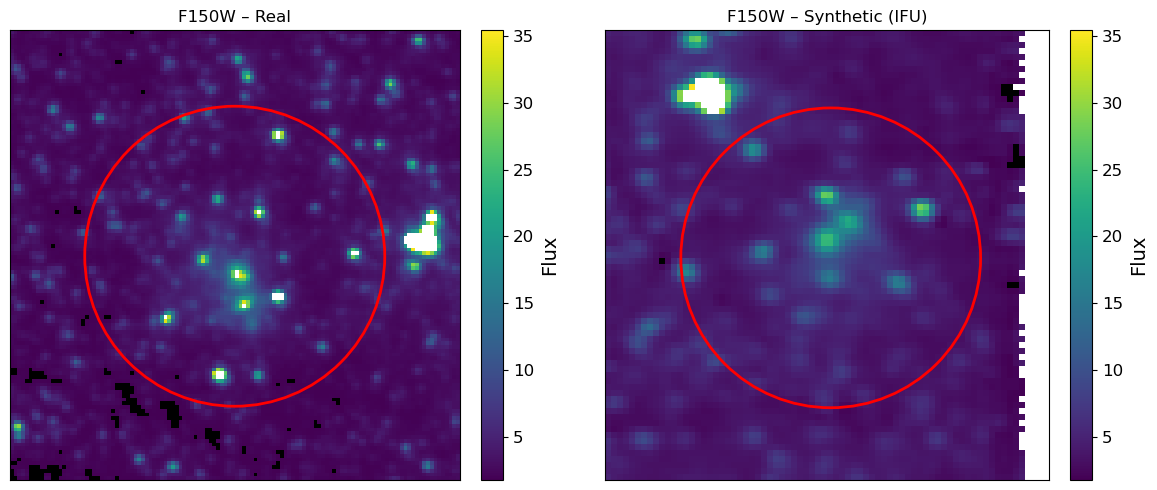

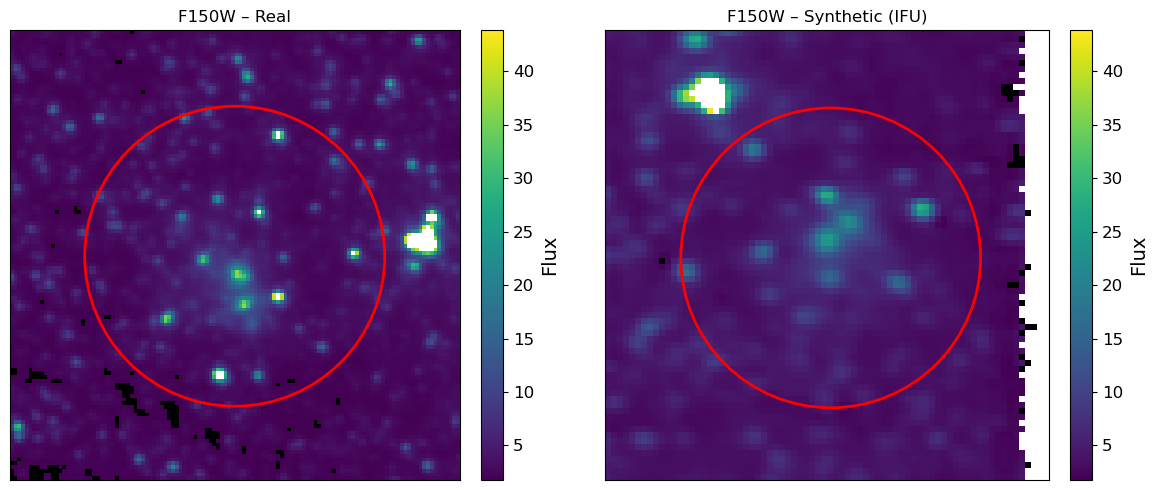

In [34]:
size = np.linspace(0, 10, 1001)

array([ 0.  ,  0.01,  0.02, ...,  9.98,  9.99, 10.  ])

In [30]:
np.linspace?

Signature:      
np.linspace(
    start,
    stop,
    num=50,
    endpoint=True,
    retstep=False,
    dtype=None,
    axis=0,
)
Call signature:  np.linspace(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function linspace at 0x7f9ed81442c0>
File:            /usr/local/Anaconda2024/lib/python3.11/site-packages/numpy/core/function_base.py
Docstring:      
Return evenly spaced numbers over a specified interval.

Returns `num` evenly spaced samples, calculated over the
interval [`start`, `stop`].

The endpoint of the interval can optionally be excluded.

.. versionchanged:: 1.16.0
    Non-scalar `start` and `stop` are now supported.

.. versionchanged:: 1.20.0
    Values are rounded towards ``-inf`` instead of ``0`` when an
    integer ``dtype`` is specified. The old behavior can
    still be obtained with ``np.linspace(start, stop, num).astype(int)``

Parameters
----------
start : array_like
    The starting value of the sequence.
stop : array_like
    The

In [37]:
11 % 2

1